## Loading the dataset

In [1]:
import pandas as pd
df = pd.read_csv("./day_month.csv")
df.head()

,production,p_per_m2,p_max,panel_area,facade_area,total_panel_area,exploitation_ratio,air_temp_mean,air_temp_max,clearsky_ghi_mean,...,relative_humidity_max,surface_pressure_mean,surface_pressure_min,surface_pressure_max,wind_direction_100m_mean,wind_direction_100m_min,wind_direction_100m_max,wind_speed_100m_mean,wind_speed_100m_min,wind_speed_100m_max
0,8.075,143.0,210.0,1.72,218.0,94.6,0.434,4.063830,6.50,61.673648,...,95.675,1025.209907,1023.175,1027.325,210.491356,114.25,281.5,3.281959,1.625,5.025
1,0.700,143.0,210.0,1.72,218.0,94.6,0.434,4.221410,5.00,61.055629,...,95.350,1029.553147,1027.750,1031.600,221.406250,115.00,273.0,3.476042,1.650,5.000
2,1.325,143.0,210.0,1.72,218.0,94.6,0.434,6.932292,8.75,89.687500,...,92.875,1004.979167,1002.000,1009.450,202.578125,153.50,255.0,6.997396,5.025,9.425
3,1.300,143.0,210.0,1.72,218.0,94.6,0.434,5.822917,7.50,89.614583,...,92.700,1004.126042,1000.750,1010.600,216.354167,181.50,259.0,7.590625,5.450,9.650
4,18.250,143.0,210.0,1.72,218.0,94.6,0.434,6.647368,11.50,154.226316,...,85.625,1019.062632,1016.375,1021.425,154.531579,123.00,190.0,5.128947,3.625,7.500


## Preoaring the (x,y) pairs

### Scaling the data

In [2]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df.values)

### Creating windows

In [3]:
production_column = 'production'

def get_target_column_index(df, target_column):
    for i, column in enumerate(df.columns):
        if column == target_column:
            return i

    return -1

In [4]:
import numpy as np

def get_windows(data, window_size=10):
    x = []
    y = []

    for i in range(window_size, len(data)):
        x.append(data[i-window_size:i])
        y.append(data[i][get_target_column_index(df, production_column)])

    return np.array(x), np.array(y)

In [5]:
window_size = 2*12  # 2*1h window
x, y = get_windows(data_scaled, window_size=window_size)

x.shape, y.shape

((6562, 24, 34), (6562,))

### Splitting the data

In [6]:
train_split_index = int(0.8 * len(df))
test_split_index = int(0.9 * len(df))

x_train, y_train = x[:train_split_index], y[:train_split_index]
x_test, y_test = x[train_split_index:test_split_index], y[train_split_index:test_split_index]
x_val, y_val = x[test_split_index:], y[test_split_index:]

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((5268, 24, 34), (5268,), (659, 24, 34), (659,), (635, 24, 34), (635,))

### Plotting the splits

In [7]:
import matplotlib.pyplot as plt


def plot_time_series(timesteps, values, label, format='-^', start=0, end=None):
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("date")
    plt.ylabel("production")

    plt.legend(fontsize=14)
    plt.grid(True)

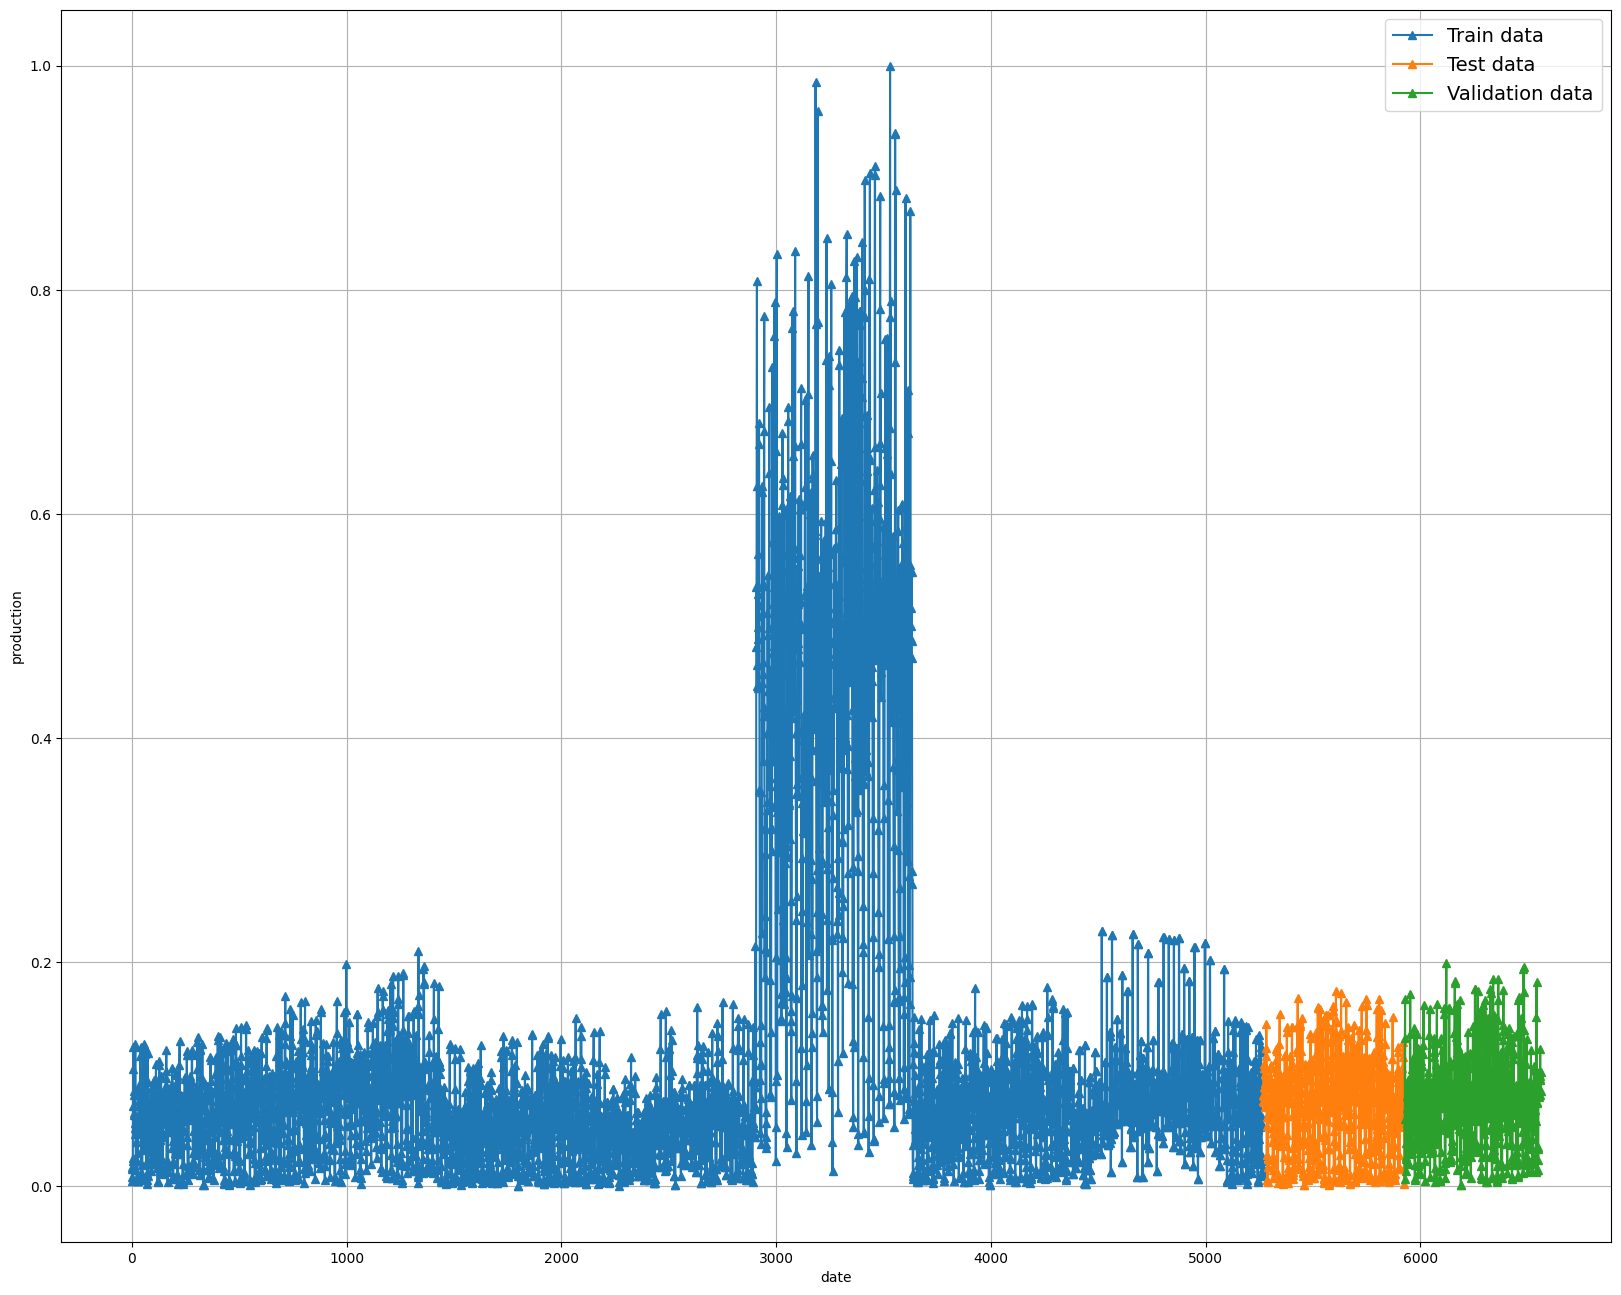

In [8]:
plt.figure(figsize=(20, 16))

timesteps = range(len(x_train))
plot_time_series(timesteps=timesteps, values=y_train, label="Train data")

timesteps = range(len(x_train), len(x_train) + len(x_test))
plot_time_series(timesteps=timesteps, values=y_test, label="Test data")

timesteps = range(len(x_train) + len(x_test),
                  len(x_train) + len(x_test) + len(x_val))
plot_time_series(timesteps=timesteps, values=y_val, label="Validation data")

### Preparing the performances metrics

In [9]:
import tensorflow as tf
from sklearn.metrics import r2_score

In [10]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'mape': mape,
    }

In [11]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae_metric = tf.keras.metrics.MeanAbsoluteError()
    mse_metric = tf.keras.metrics.MeanSquaredError()

    mae_metric.update_state(y_true, y_pred)
    mse_metric.update_state(y_true, y_pred)

    mae = mae_metric.result().numpy()
    mse = mse_metric.result().numpy()
    r2 = r2_score(y_true.numpy(), y_pred.numpy()) 

    return {
        "mae": mae,
        "mse": mse,
        "r2": r2
    }

## Modeling

In [12]:
import os
import tensorflow as tf

from keras.layers import Dense, Dropout, LSTM, Flatten, ConvLSTM1D, MaxPool1D, GlobalMaxPool1D, Conv1D, Conv2D
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

### Plotting the loss

In [13]:
def plot_loss(history):
    plt.figure(figsize=(20, 8))

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

### Creating callbacks

In [14]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)


def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              verbose=0,
                                              save_best_only=True)

### Utils function

In [15]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

## ConvLSTM

#### Preparing the model

In [16]:
x_train_conv_lstm = np.expand_dims(x_train, axis=2)
x_val_conv_lstm = np.expand_dims(x_val, axis=2)
x_test_conv_lstm = np.expand_dims(x_test, axis=2)

print(f"{x_train.shape} -> {x_train_conv_lstm.shape}")

(5268, 24, 34) -> (5268, 24, 1, 34)


In [17]:
tf.random.set_seed(42)

input_shape = (x_train_conv_lstm.shape[1:])
conv_lstm_model = tf.keras.Sequential([
    ConvLSTM1D(filters=64, kernel_size=(1,), activation='tanh',
               return_sequences=True, input_shape=input_shape),
    ConvLSTM1D(filters=64, kernel_size=(1,),
               activation='tanh', return_sequences=False),
    Flatten(),
    Dense(units=64, activation='relu'),
    Dense(1, activation="linear")
], name="model_conv_lstm.keras")

conv_lstm_model.compile(loss="mae",
                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

conv_lstm_model.summary()

C:\Users\peesc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "model_conv_lstm.keras"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm1d (ConvLSTM1D)             │ (None, 24, 1, 64)           │          25,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm1d_1 (ConvLSTM1D)           │ (None, 1, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,593 (244.50 KB)

 Trainable params: 62,593 (244.50 KB)

 Non-trainable params: 0 (0.00 B)

#### Training the model convlstm

In [18]:
import os
import time
import logging
from codecarbon import EmissionsTracker


os.makedirs('emissions', exist_ok=True)

tracker_conv_lstm = EmissionsTracker(
    project_name="PEWH",
    co2_signal_api_token="9RkoBO6iipmoq",
    log_level=logging.INFO,
    output_file="emissions_conv_lstm.csv",
    output_dir='./emissions/',
    save_to_file=True,
    measure_power_secs=10
)

[codecarbon INFO @ 03:21:16] [setup] RAM Tracking...
[codecarbon INFO @ 03:21:16] [setup] CPU Tracking...
[codecarbon WARNING @ 03:21:16] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 03:21:18] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-9700K CPU @ 3.60GHz
[codecarbon INFO @ 03:21:18] [setup] GPU Tracking...
[codecarbon INFO @ 03:21:18] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 03:21:18] >>> Tracker's metadata:
[codecarbon INFO @ 03:21:18]   Platform system: Windows-10-10.0.19045-SP0
[codecarbon INFO @ 03:21:18]   Python version: 3.12.3
[codecarbon INFO @ 03:21:18]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 03:21:18]   Available RAM : 31.935 GB
[codecarbon INFO @ 03:21:18]   CPU count: 8
[codecarbon INFO @ 03:21:18]   CPU model: Intel(R) Core(TM) i7-9700K CPU @ 3.60GHz
[codecarbon INFO @ 03:21:18]   GPU count: 1
[codecarbon INFO @ 03:21:18]   GPU mo

In [19]:
def start_training_conv_lstm():
    start_time = time.time()
    conv_lstm_history = conv_lstm_model.fit(x=x_train_conv_lstm,
                                            y=y_train,
                                            epochs=300,
                                            verbose=1,
                                            batch_size=512,
                                            validation_data=(
                                                x_val_conv_lstm, y_val),
                                            callbacks=[create_model_checkpoint(model_name=conv_lstm_model.name)])
    training_duration = time.time() - start_time

    return conv_lstm_history, training_duration

In [20]:
tracker_conv_lstm.start()
try:
    history_conv_lstm, training_duration_conv_lstm = start_training_conv_lstm()
finally:
    tracker_conv_lstm.stop()

Epoch 1/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 0.1084 - val_loss: 0.0366
Epoch 2/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0494 - val_loss: 0.0318
Epoch 3/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0470 - val_loss: 0.0306
Epoch 4/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0448 - val_loss: 0.0297
Epoch 5/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0438 - val_loss: 0.0310
Epoch 6/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0425 - val_loss: 0.0289
Epoch 7/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0428 - val_loss: 0.0292
Epoch 8/300
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0408

[codecarbon INFO @ 03:21:31] Energy consumed for RAM : 0.000033 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:21:31] Energy consumed for all CPUs : 0.000132 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:21:31] Energy consumed for all GPUs : 0.000085 kWh. Total GPU Power : 30.55196774343571 W
[codecarbon INFO @ 03:21:31] 0.000250 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0408 - val_loss: 0.0294
Epoch 9/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0391 - val_loss: 0.0266
Epoch 10/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0389 - val_loss: 0.0283
Epoch 11/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0376 - val_loss: 0.0271
Epoch 12/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0383 - val_loss: 0.0289
Epoch 13/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0362 - val_loss: 0.0277
Epoch 14/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0357 - val_loss: 0.0265
Epoch 15/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0353 - val_loss: 0.0289
Epoch 16/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0356 - val_loss: 0.0267
Epoch 17/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0359 - val_loss: 0.0301
Epoch 18/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0355 - val_loss: 0.0269
Epoch 19/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - lo

[codecarbon INFO @ 03:21:41] Energy consumed for RAM : 0.000067 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:21:41] Energy consumed for all CPUs : 0.000264 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:21:41] Energy consumed for all GPUs : 0.000143 kWh. Total GPU Power : 20.79364487189767 W
[codecarbon INFO @ 03:21:41] 0.000474 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0343 - val_loss: 0.0275
Epoch 24/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0345 - val_loss: 0.0265
Epoch 25/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0346 - val_loss: 0.0282
Epoch 26/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0345 - val_loss: 0.0273
Epoch 27/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0356 - val_loss: 0.0276
Epoch 28/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0361 - val_loss: 0.0273
Epoch 29/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0360 - val_loss: 0.0305
Epoch 30/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0351 - val_loss: 0.0261
Epoch 31/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0345 - val_loss: 0.0257
Epoch 32/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0338 - val_loss: 0.0257
Epoch 33/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0337 - val_loss: 0.0254
Epoch 34/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - l

[codecarbon INFO @ 03:21:51] Energy consumed for RAM : 0.000100 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:21:51] Energy consumed for all CPUs : 0.000396 kWh. Total CPU Power : 47.5 W


 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0339

[codecarbon INFO @ 03:21:51] Energy consumed for all GPUs : 0.000228 kWh. Total GPU Power : 30.64478088724341 W
[codecarbon INFO @ 03:21:51] 0.000724 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0338 - val_loss: 0.0264
Epoch 38/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0336 - val_loss: 0.0256
Epoch 39/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0332 - val_loss: 0.0253
Epoch 40/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0333 - val_loss: 0.0252
Epoch 41/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0330 - val_loss: 0.0257
Epoch 42/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0338 - val_loss: 0.0253
Epoch 43/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0336 - val_loss: 0.0258
Epoch 44/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0346 - val_loss: 0.0257
Epoch 45/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0345 - val_loss: 0.0252
Epoch 46/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0338 - val_loss: 0.0253
Epoch 47/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0334 - val_loss: 0.0251
Epoch 48/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - l

[codecarbon INFO @ 03:22:01] Energy consumed for RAM : 0.000133 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:22:01] Energy consumed for all CPUs : 0.000528 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:22:01] Energy consumed for all GPUs : 0.000283 kWh. Total GPU Power : 19.704580657079312 W
[codecarbon INFO @ 03:22:01] 0.000944 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0325 - val_loss: 0.0248
Epoch 53/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0325 - val_loss: 0.0256
Epoch 54/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0331 - val_loss: 0.0269
Epoch 55/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0335 - val_loss: 0.0264
Epoch 56/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0333 - val_loss: 0.0248
Epoch 57/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0327 - val_loss: 0.0247
Epoch 58/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0325 - val_loss: 0.0252
Epoch 59/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0326 - val_loss: 0.0248
Epoch 60/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0323 - val_loss: 0.0247
Epoch 61/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0320 - val_loss: 0.0257
Epoch 62/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0323 - val_loss: 0.0254
Epoch 63/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - l

[codecarbon INFO @ 03:22:11] Energy consumed for RAM : 0.000166 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:22:12] Energy consumed for all CPUs : 0.000660 kWh. Total CPU Power : 47.5 W


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0325

[codecarbon INFO @ 03:22:12] Energy consumed for all GPUs : 0.000341 kWh. Total GPU Power : 20.857754115642596 W
[codecarbon INFO @ 03:22:12] 0.001168 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0321 - val_loss: 0.0244
Epoch 68/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0313 - val_loss: 0.0244
Epoch 69/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0316 - val_loss: 0.0249
Epoch 70/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0314 - val_loss: 0.0248
Epoch 71/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0311 - val_loss: 0.0244
Epoch 72/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0319 - val_loss: 0.0248
Epoch 73/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0312 - val_loss: 0.0240
Epoch 74/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0312 - val_loss: 0.0241
Epoch 75/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0311 - val_loss: 0.0247
Epoch 76/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0316 - val_loss: 0.0246
Epoch 77/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0314 - val_loss: 0.0262
Epoch 78/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - l

[codecarbon INFO @ 03:22:21] Energy consumed for RAM : 0.000200 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:22:22] Energy consumed for all CPUs : 0.000792 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:22:22] Energy consumed for all GPUs : 0.000405 kWh. Total GPU Power : 23.23964534748287 W
[codecarbon INFO @ 03:22:22] 0.001397 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0312 - val_loss: 0.0242
Epoch 82/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0311 - val_loss: 0.0242
Epoch 83/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0311 - val_loss: 0.0246
Epoch 84/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0309 - val_loss: 0.0242
Epoch 85/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0306 - val_loss: 0.0241
Epoch 86/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0307 - val_loss: 0.0237
Epoch 87/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0308 - val_loss: 0.0241
Epoch 88/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0306 - val_loss: 0.0240
Epoch 89/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0307 - val_loss: 0.0233
Epoch 90/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0312 - val_loss: 0.0235
Epoch 91/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0308 - val_loss: 0.0247
Epoch 92/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - l

[codecarbon INFO @ 03:22:32] Energy consumed for RAM : 0.000233 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:22:32] Energy consumed for all CPUs : 0.000924 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:22:32] Energy consumed for all GPUs : 0.000489 kWh. Total GPU Power : 30.229319325169 W
[codecarbon INFO @ 03:22:32] 0.001647 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0309 - val_loss: 0.0241
Epoch 97/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0307 - val_loss: 0.0265
Epoch 98/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0322 - val_loss: 0.0242
Epoch 99/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0309 - val_loss: 0.0244
Epoch 100/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0310 - val_loss: 0.0260
Epoch 101/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0316 - val_loss: 0.0238
Epoch 102/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0314 - val_loss: 0.0239
Epoch 103/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0312 - val_loss: 0.0258
Epoch 104/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0322 - val_loss: 0.0236
Epoch 105/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0307 - val_loss: 0.0235
Epoch 106/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0308 - val_loss: 0.0229
Epoch 107/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/

[codecarbon INFO @ 03:22:42] Energy consumed for RAM : 0.000266 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:22:42] Energy consumed for all CPUs : 0.001056 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:22:42] Energy consumed for all GPUs : 0.000560 kWh. Total GPU Power : 25.275640102048488 W
[codecarbon INFO @ 03:22:42] 0.001882 kWh of electricity used since the beginning.


 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0305

[codecarbon INFO @ 03:22:42] 0.000587 g.CO2eq/s mean an estimation of 18.523297765833462 kg.CO2eq/year


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0303 - val_loss: 0.0231
Epoch 111/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0306 - val_loss: 0.0235
Epoch 112/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0302 - val_loss: 0.0228
Epoch 113/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0302 - val_loss: 0.0226
Epoch 114/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0305 - val_loss: 0.0234
Epoch 115/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0301 - val_loss: 0.0230
Epoch 116/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0302 - val_loss: 0.0249
Epoch 117/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0310 - val_loss: 0.0235
Epoch 118/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0298 - val_loss: 0.0230
Epoch 119/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0292 - val_loss: 0.0227
Epoch 120/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0290 - val_loss: 0.0226
Epoch 121/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66

[codecarbon INFO @ 03:22:52] Energy consumed for RAM : 0.000299 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:22:52] Energy consumed for all CPUs : 0.001188 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:22:52] Energy consumed for all GPUs : 0.000644 kWh. Total GPU Power : 30.183984204833877 W
[codecarbon INFO @ 03:22:52] 0.002131 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0300 - val_loss: 0.0234
Epoch 125/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0293 - val_loss: 0.0233
Epoch 126/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0290 - val_loss: 0.0238
Epoch 127/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0293 - val_loss: 0.0243
Epoch 128/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0296 - val_loss: 0.0227
Epoch 129/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0295 - val_loss: 0.0238
Epoch 130/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0298 - val_loss: 0.0233
Epoch 131/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0297 - val_loss: 0.0235
Epoch 132/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0291 - val_loss: 0.0229
Epoch 133/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0288 - val_loss: 0.0225
Epoch 134/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0296 - val_loss: 0.0226
Epoch 135/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60

[codecarbon INFO @ 03:23:02] Energy consumed for RAM : 0.000333 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:23:02] Energy consumed for all CPUs : 0.001320 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:23:02] Energy consumed for all GPUs : 0.000719 kWh. Total GPU Power : 27.13993758739597 W
[codecarbon INFO @ 03:23:02] 0.002372 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0283 - val_loss: 0.0234
Epoch 139/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0292 - val_loss: 0.0225
Epoch 140/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0291 - val_loss: 0.0232
Epoch 141/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0290 - val_loss: 0.0224
Epoch 142/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0287 - val_loss: 0.0227
Epoch 143/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0291 - val_loss: 0.0233
Epoch 144/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0290 - val_loss: 0.0224
Epoch 145/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0288 - val_loss: 0.0225
Epoch 146/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0285 - val_loss: 0.0220
Epoch 147/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0283 - val_loss: 0.0222
Epoch 148/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0277 - val_loss: 0.0222
Epoch 149/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60

[codecarbon INFO @ 03:23:12] Energy consumed for RAM : 0.000366 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:23:12] Energy consumed for all CPUs : 0.001452 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:23:12] Energy consumed for all GPUs : 0.000782 kWh. Total GPU Power : 22.828899124461408 W
[codecarbon INFO @ 03:23:12] 0.002601 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0286 - val_loss: 0.0221
Epoch 154/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0278 - val_loss: 0.0222
Epoch 155/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0280 - val_loss: 0.0221
Epoch 156/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0289 - val_loss: 0.0231
Epoch 157/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0286 - val_loss: 0.0231
Epoch 158/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0280 - val_loss: 0.0219
Epoch 159/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0274 - val_loss: 0.0229
Epoch 160/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0274 - val_loss: 0.0212
Epoch 161/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0275 - val_loss: 0.0225
Epoch 162/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0279 - val_loss: 0.0282
Epoch 163/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0309 - val_loss: 0.0237
Epoch 164/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61

[codecarbon INFO @ 03:23:22] Energy consumed for RAM : 0.000399 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:23:22] Energy consumed for all CPUs : 0.001585 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:23:22] Energy consumed for all GPUs : 0.000843 kWh. Total GPU Power : 21.76013940141813 W
[codecarbon INFO @ 03:23:22] 0.002827 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0271 - val_loss: 0.0228
Epoch 170/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0271 - val_loss: 0.0224
Epoch 171/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0270 - val_loss: 0.0232
Epoch 172/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0270 - val_loss: 0.0232
Epoch 173/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0278 - val_loss: 0.0226
Epoch 174/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0271 - val_loss: 0.0215
Epoch 175/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0273 - val_loss: 0.0213
Epoch 176/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0282 - val_loss: 0.0220
Epoch 177/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0278 - val_loss: 0.0214
Epoch 178/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0279 - val_loss: 0.0218
Epoch 179/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0272 - val_loss: 0.0221
Epoch 180/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59

[codecarbon INFO @ 03:23:32] Energy consumed for RAM : 0.000432 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:23:32] Energy consumed for all CPUs : 0.001716 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:23:32] Energy consumed for all GPUs : 0.000897 kWh. Total GPU Power : 19.59986106995062 W
[codecarbon INFO @ 03:23:32] 0.003046 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0275 - val_loss: 0.0215
Epoch 184/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0269 - val_loss: 0.0222
Epoch 185/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0269 - val_loss: 0.0212
Epoch 186/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0265 - val_loss: 0.0217
Epoch 187/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0262 - val_loss: 0.0212
Epoch 188/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0257 - val_loss: 0.0206
Epoch 189/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0259 - val_loss: 0.0227
Epoch 190/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0268 - val_loss: 0.0222
Epoch 191/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0271 - val_loss: 0.0204
Epoch 192/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0270 - val_loss: 0.0214
Epoch 193/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0267 - val_loss: 0.0213
Epoch 194/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61

[codecarbon INFO @ 03:23:42] Energy consumed for RAM : 0.000465 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:23:42] Energy consumed for all CPUs : 0.001848 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:23:42] Energy consumed for all GPUs : 0.000951 kWh. Total GPU Power : 19.389178172397465 W
[codecarbon INFO @ 03:23:42] 0.003265 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0255 - val_loss: 0.0211
Epoch 199/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0257 - val_loss: 0.0220
Epoch 200/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0260 - val_loss: 0.0239
Epoch 201/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0281 - val_loss: 0.0216
Epoch 202/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0258 - val_loss: 0.0206
Epoch 203/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0260 - val_loss: 0.0216
Epoch 204/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0262 - val_loss: 0.0221
Epoch 205/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0259 - val_loss: 0.0202
Epoch 206/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0254 - val_loss: 0.0231
Epoch 207/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0255 - val_loss: 0.0210
Epoch 208/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0250 - val_loss: 0.0210
Epoch 209/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60

[codecarbon INFO @ 03:23:52] Energy consumed for RAM : 0.000499 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:23:52] Energy consumed for all CPUs : 0.001980 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:23:52] Energy consumed for all GPUs : 0.001005 kWh. Total GPU Power : 19.447441510894528 W
[codecarbon INFO @ 03:23:52] 0.003484 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0253 - val_loss: 0.0209
Epoch 214/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0259 - val_loss: 0.0215
Epoch 215/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0259 - val_loss: 0.0206
Epoch 216/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0255 - val_loss: 0.0224
Epoch 217/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0263 - val_loss: 0.0208
Epoch 218/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0256 - val_loss: 0.0225
Epoch 219/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0255 - val_loss: 0.0203
Epoch 220/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0250 - val_loss: 0.0206
Epoch 221/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0248 - val_loss: 0.0217
Epoch 222/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0251 - val_loss: 0.0211
Epoch 223/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0252 - val_loss: 0.0220
Epoch 224/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59

[codecarbon INFO @ 03:24:02] Energy consumed for RAM : 0.000532 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:24:02] Energy consumed for all CPUs : 0.002112 kWh. Total CPU Power : 47.5 W


 4/11 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0240

[codecarbon INFO @ 03:24:02] Energy consumed for all GPUs : 0.001074 kWh. Total GPU Power : 24.798069735259567 W
[codecarbon INFO @ 03:24:02] 0.003718 kWh of electricity used since the beginning.


 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0241

[codecarbon INFO @ 03:24:02] 0.000573 g.CO2eq/s mean an estimation of 18.08222807406942 kg.CO2eq/year


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0245 - val_loss: 0.0218
Epoch 229/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0250 - val_loss: 0.0209
Epoch 230/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0242 - val_loss: 0.0211
Epoch 231/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0243 - val_loss: 0.0205
Epoch 232/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0242 - val_loss: 0.0202
Epoch 233/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0241 - val_loss: 0.0197
Epoch 234/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0244 - val_loss: 0.0203
Epoch 235/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0240 - val_loss: 0.0203
Epoch 236/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0240 - val_loss: 0.0209
Epoch 237/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0239 - val_loss: 0.0218
Epoch 238/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0240 - val_loss: 0.0209
Epoch 239/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59

[codecarbon INFO @ 03:24:12] Energy consumed for RAM : 0.000565 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:24:12] Energy consumed for all CPUs : 0.002244 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:24:12] Energy consumed for all GPUs : 0.001129 kWh. Total GPU Power : 19.785261614953356 W
[codecarbon INFO @ 03:24:12] 0.003939 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0241 - val_loss: 0.0196
Epoch 244/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0233 - val_loss: 0.0209
Epoch 245/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0240 - val_loss: 0.0205
Epoch 246/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0241 - val_loss: 0.0208
Epoch 247/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0239 - val_loss: 0.0211
Epoch 248/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0236 - val_loss: 0.0197
Epoch 249/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0238 - val_loss: 0.0209
Epoch 250/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0233 - val_loss: 0.0210
Epoch 251/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0234 - val_loss: 0.0206
Epoch 252/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0236 - val_loss: 0.0215
Epoch 253/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0245 - val_loss: 0.0206
Epoch 254/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62

[codecarbon INFO @ 03:24:22] Energy consumed for RAM : 0.000598 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:24:22] Energy consumed for all CPUs : 0.002376 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:24:22] Energy consumed for all GPUs : 0.001183 kWh. Total GPU Power : 19.482624690574877 W
[codecarbon INFO @ 03:24:22] 0.004158 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0237 - val_loss: 0.0197
Epoch 259/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0226 - val_loss: 0.0202
Epoch 260/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0234 - val_loss: 0.0207
Epoch 261/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0235 - val_loss: 0.0192
Epoch 262/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0223 - val_loss: 0.0194
Epoch 263/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0226 - val_loss: 0.0192
Epoch 264/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0227 - val_loss: 0.0202
Epoch 265/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0229 - val_loss: 0.0205
Epoch 266/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0230 - val_loss: 0.0197
Epoch 267/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0233 - val_loss: 0.0191
Epoch 268/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0228 - val_loss: 0.0200
Epoch 269/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60

[codecarbon INFO @ 03:24:32] Energy consumed for RAM : 0.000632 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:24:32] Energy consumed for all CPUs : 0.002508 kWh. Total CPU Power : 47.5 W


 2/11 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0232

[codecarbon INFO @ 03:24:32] Energy consumed for all GPUs : 0.001238 kWh. Total GPU Power : 19.519334337381032 W
[codecarbon INFO @ 03:24:32] 0.004378 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0235 - val_loss: 0.0194
Epoch 274/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0225 - val_loss: 0.0187
Epoch 275/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0220 - val_loss: 0.0199
Epoch 276/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0226 - val_loss: 0.0198
Epoch 277/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0222 - val_loss: 0.0207
Epoch 278/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0240 - val_loss: 0.0184
Epoch 279/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0221 - val_loss: 0.0194
Epoch 280/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0224 - val_loss: 0.0188
Epoch 281/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0224 - val_loss: 0.0195
Epoch 282/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0221 - val_loss: 0.0191
Epoch 283/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0225 - val_loss: 0.0209
Epoch 284/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59

[codecarbon INFO @ 03:24:42] Energy consumed for RAM : 0.000665 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:24:42] Energy consumed for all CPUs : 0.002640 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:24:42] Energy consumed for all GPUs : 0.001292 kWh. Total GPU Power : 19.496382055944157 W
[codecarbon INFO @ 03:24:42] 0.004597 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0223 - val_loss: 0.0188
Epoch 289/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0220 - val_loss: 0.0195
Epoch 290/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0220 - val_loss: 0.0203
Epoch 291/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0222 - val_loss: 0.0189
Epoch 292/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0216 - val_loss: 0.0189
Epoch 293/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0221 - val_loss: 0.0192
Epoch 294/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0213 - val_loss: 0.0186
Epoch 295/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0214 - val_loss: 0.0189
Epoch 296/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0220 - val_loss: 0.0189
Epoch 297/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0215 - val_loss: 0.0185
Epoch 298/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0210 - val_loss: 0.0195
Epoch 299/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61

[codecarbon INFO @ 03:24:50] Energy consumed for RAM : 0.000693 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:24:50] Energy consumed for all CPUs : 0.002752 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:24:50] Energy consumed for all GPUs : 0.001337 kWh. Total GPU Power : 19.239049403464385 W
[codecarbon INFO @ 03:24:50] 0.004783 kWh of electricity used since the beginning.


#### Ploting the loss

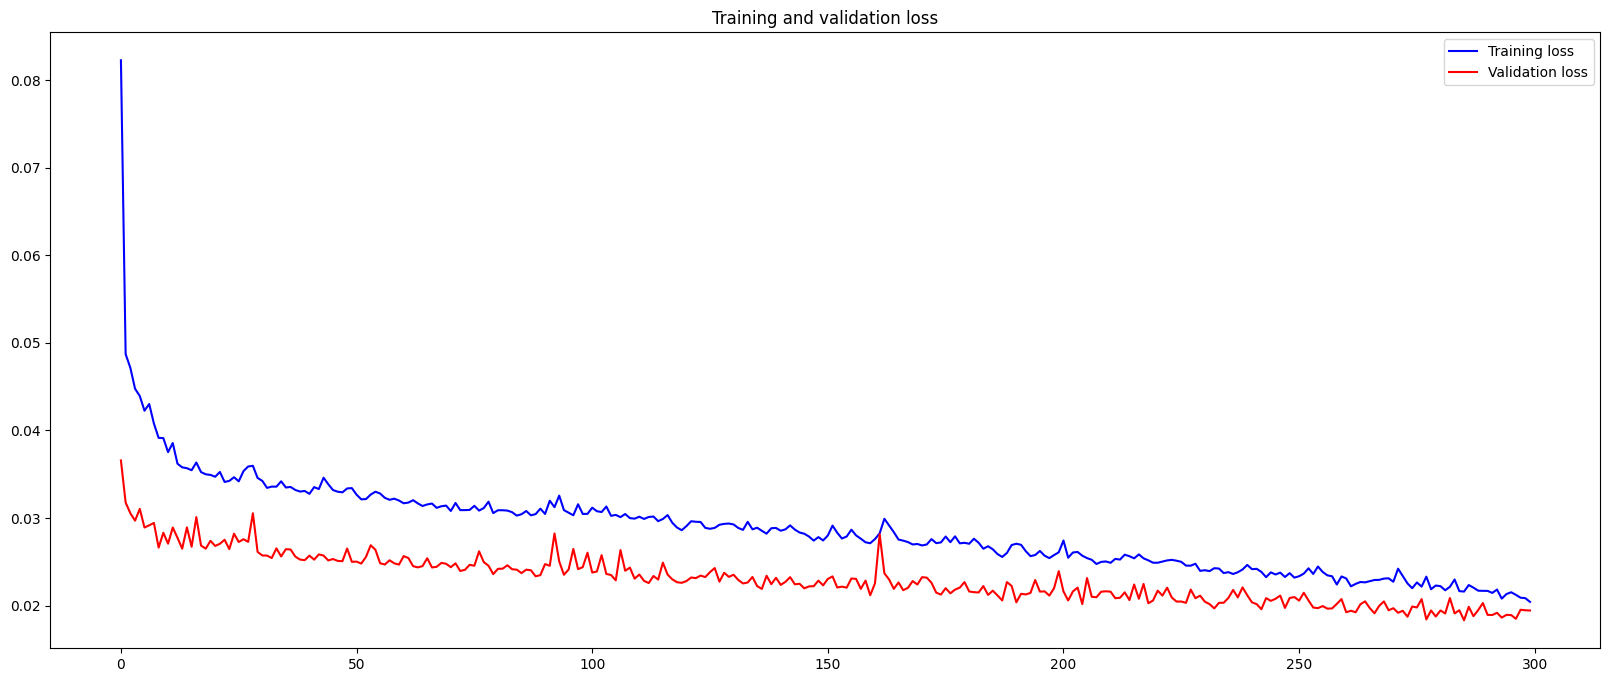

In [21]:
plot_loss(history_conv_lstm)

In [22]:
conv_lstm_model = tf.keras.models.load_model(
    "model_experiments/model_conv_lstm.keras")

model_preds = make_preds(conv_lstm_model, x_test_conv_lstm)
model_results = evaluate_preds(y_true=tf.squeeze(y_test),
                               y_pred=model_preds)

model_results

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


{'mae': 0.01650124, 'mse': 0.00047198712, 'r2': 0.731475830078125}

#### Plot predictions

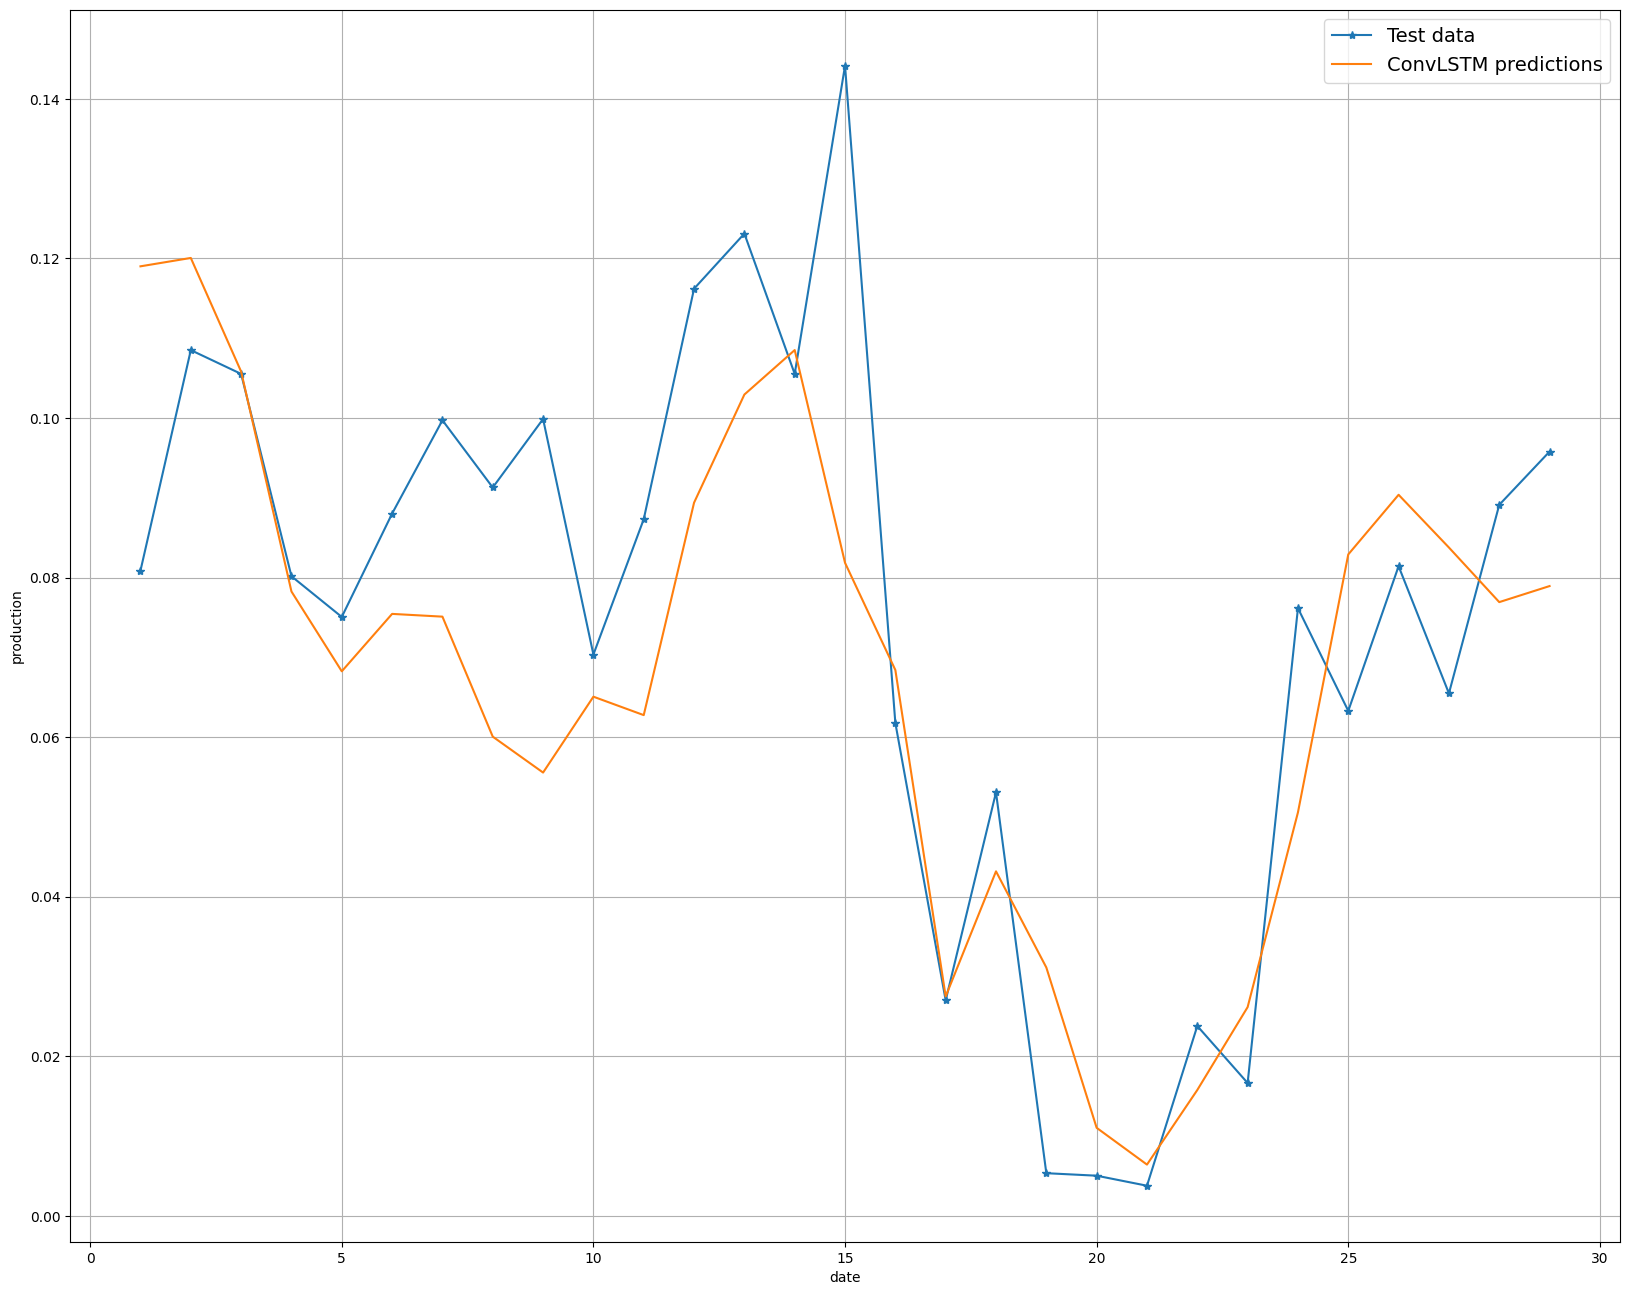

In [23]:
import numpy as np

start_offset = 1
end_offset = 30
plt.figure(figsize=(20, 16))


plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=y_test,
    start=start_offset,
    end=end_offset,
    format='-*',
    label="Test data"
)

plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=model_preds,
    start=start_offset,
    end=end_offset,
    format="-",
    label="ConvLSTM predictions"
)

In [24]:
import time
from deap import base, creator, tools
import random

# ========= Fonction modèle =========
def create_model(filters, kernel_size, activation, dense_units, learning_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.ConvLSTM1D(filters=int(filters), kernel_size=(int(kernel_size),), activation=activation,
                                   return_sequences=True, input_shape=x_train_conv_lstm.shape[1:]),
        tf.keras.layers.ConvLSTM1D(filters=int(filters), kernel_size=(int(kernel_size),), activation=activation,
                                   return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=int(dense_units), activation='relu'),
        tf.keras.layers.Dense(1, activation="linear")
    ])
    model.compile(loss="mae", optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    return model

# ========= Fonction évaluation =========
def evaluate(individual):
    filters, kernel_size, activation, dense_units, learning_rate = individual
    model = create_model(filters, kernel_size, activation, dense_units, learning_rate)
    
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=1,
        restore_best_weights=True
    )
    
    history = model.fit(
        x_train_conv_lstm, y_train,
        epochs=2,
        batch_size=128,
        verbose=0,
        validation_data=(x_val_conv_lstm, y_val),
        callbacks=[early_stop]
    )
    
    mae = history.history['val_loss'][-1]
    return (mae,)

# ========= Mutation et croisement =========
def mut_mixed(ind, indpb=0.2):
    for i in range(len(ind)):
        if i == 1:
            continue
        if random.random() < indpb:
            if isinstance(ind[i], float):
                ind[i] += random.gauss(0, 0.001)
                ind[i] = max(0.0001, min(0.01, ind[i]))
            elif isinstance(ind[i], int):
                ind[i] += random.randint(-8, 8)
                ind[i] = max(1, min(256, ind[i]))
            elif isinstance(ind[i], str):
                ind[i] = 'relu' if ind[i] == 'tanh' else 'tanh'
    return ind,

def cx_mixed(ind1, ind2):
    for i in range(len(ind1)):
        if random.random() < 0.5:
            ind1[i], ind2[i] = ind2[i], ind1[i]
    return ind1, ind2

# ========= Configuration DEAP =========
if not hasattr(creator, "FitnessMin"):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
if not hasattr(creator, "Individual"):
    creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("filters", random.choice, [32, 64, 128])
toolbox.register("kernel_size", random.choice, [1])
toolbox.register("activation", random.choice, ['relu', 'tanh'])
toolbox.register("dense_units", random.choice, [32, 64, 128])
toolbox.register("learning_rate", random.uniform, 0.0001, 0.008)

toolbox.register("individual", tools.initCycle, creator.Individual,
    (toolbox.filters, toolbox.kernel_size, toolbox.activation, toolbox.dense_units, toolbox.learning_rate), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cx_mixed)
toolbox.register("mutate", mut_mixed, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# ========= Exécution GA avec meilleur global =========
start_ga_time = time.time()

n_generations = 4
population_size = 10

population = toolbox.population(n=population_size)
best_overall = None

for gen in range(n_generations):
    print(f"\n Génération {gen+1}")
    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    # Suivi du meilleur global
    gen_best = tools.selBest(population, 1)[0]
    if best_overall is None or gen_best.fitness.values[0] < best_overall.fitness.values[0]:
        best_overall = creator.Individual(gen_best)
        best_overall.fitness.values = gen_best.fitness.values

    print(" Population :")
    for i, ind in enumerate(population):
        print(f"  ➤ Individu {i+1}: {ind} ➤ MAE = {ind.fitness.values[0]:.4f}")

    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    for c1, c2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.5:
            toolbox.mate(c1, c2)
            del c1.fitness.values, c2.fitness.values

    for mutant in offspring:
        if random.random() < 0.2:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    invalids = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = list(map(toolbox.evaluate, invalids))
    for ind, fit in zip(invalids, fitnesses):
        ind.fitness.values = fit

    population[:] = offspring

end_ga_time = time.time()

# ========= Réentraînement final =========
print(f"\n Meilleurs hyperparamètres globaux trouvés : {best_overall}")
filters, kernel_size, activation, dense_units, learning_rate = best_overall
model = create_model(filters, kernel_size, activation, dense_units, learning_rate)

start_train_opt = time.time()
model.fit(x_train_conv_lstm, y_train, epochs=30, batch_size=512, verbose=0,
          validation_data=(x_val_conv_lstm, y_val))
training_time_opt = time.time() - start_train_opt

# ========= Évaluation finale =========
y_pred = model.predict(x_test_conv_lstm)
r2 = r2_score(y_test, y_pred)
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mae_metric.update_state(y_test, y_pred)
mae = mae_metric.result().numpy()


# ========= Affichage final =========
print("\n Résumé des performances :")
print(f"  ➤ R² de base              : {model_results['r2']:.4f}")
print(f"  ➤ MAE de base             : {model_results['mae']:.4f}")
print(f"  ➤ Temps entraînement base : {training_duration_conv_lstm:.2f} s")
print(f"  ➤ R² optimisé             : {r2:.4f}")
print(f"  ➤ MAE optimisé            : {mae:.4f}")
print(f"  ➤ Temps entraînement opti : {training_time_opt:.2f} s")
print(f"  ➤ Temps GA total          : {end_ga_time - start_ga_time:.2f} s")
print(f"  ➤ Hyperparamètres choisis : {best_overall}")



 Génération 1


C:\Users\peesc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 Population :
  ➤ Individu 1: [64, 1, 'tanh', 128, 0.00047361274987293083] ➤ MAE = 0.0295
  ➤ Individu 2: [128, 1, 'relu', 128, 0.0036909175284319386] ➤ MAE = 0.0302
  ➤ Individu 3: [32, 1, 'tanh', 64, 0.005703064758898908] ➤ MAE = 0.0319
  ➤ Individu 4: [128, 1, 'tanh', 32, 0.00600481874748745] ➤ MAE = 0.0327
  ➤ Individu 5: [32, 1, 'relu', 128, 0.005451928891233851] ➤ MAE = 0.0320
  ➤ Individu 6: [64, 1, 'relu', 64, 0.001980206020887205] ➤ MAE = 0.0300
  ➤ Individu 7: [128, 1, 'tanh', 64, 0.002668830218995846] ➤ MAE = 0.0316
  ➤ Individu 8: [128, 1, 'tanh', 32, 0.006828881878963634] ➤ MAE = 0.0309
  ➤ Individu 9: [64, 1, 'relu', 32, 0.006767170980327947] ➤ MAE = 0.0353
  ➤ Individu 10: [128, 1, 'relu', 32, 0.005394544390359192] ➤ MAE = 0.0315

 Génération 2
 Population :
  ➤ Individu 1: [128, 1, 'relu', 128, 0.0036909175284319386] ➤ MAE = 0.0315
  ➤ Individu 2: [128, 1, 'relu', 128, 0.0036909175284319386] ➤ MAE = 0.0302
  ➤ Individu 3: [64, 1, 'relu', 64, 0.001980206020887205] ➤ MAE 